In this notebook we are going to tackle the problem of bank statement categorization. The data at hand is a resample of data managed by a fintech, and thus is not the real data (there are many repeated rows (thus facilitating the task of finding patterns), however, this seems to be common in real life as well and would very well serve us to practice the process of categorizing income and expenses in bank statements.

The initial labeling has been done by an external provider, and there are a lot (25%) of the cases which are "Desconocidos" (unkown), so in the end we will come up with some ideas to improve this situation.

Let's dive into it!

## 1. Anonymizing ID numbers

The first part of the notebook will be to create a generic function that anonymize valid ID numbers of physical people in Spain. These numbers have some characteristics that we can find [here](http://www.interior.gob.es/ca/web/servicios-al-ciudadano/dni/calculo-del-digito-de-control-del-nif-nie). In case of bank statement analysis, this may be useful to anonymize personal numbers (ID, credit cards, etc.) in order to comply with regulation and derive insights from anonymized data

In [1]:
import re
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

from IPython.core.debugger import set_trace

In [2]:
#Example strings
random_string_1 ='''
45813753F  45813753F  fdbfaosdnf61735593Mbbo  er9834y09 lk vas difhsi df09694474C alFNOASNDOFGNS·&/()=()(/
DNSANDUFNAOIRUG oingkmsoigma ri lkjBAFPAEUH FOIWEJ RIOEAWP9RHU ADNVPAOIWEG POWEMRWMT39809823049OIEFAIDFÌAJ 
SIN KJSANDG8926956+29+9+FDSOII325457&()/)=(=)
ANSDGJSKDGJSAKDGBJAIEPOQIWH9RT8Q42HNQ34PIO5'0 PBAD OIUABF AUIFD AOISDUFG 0Q7WGERGQWIGUEORIUQ0'943UT HP9Q84 
IDLKFNASÑDN nsoidnhX5615034Klñskdnfhisndfñlkhnsfd  X3618165N hs30233X3618165N295W30233295W30233295W
naipdusng aiuhg 9reh grg98her g89374093850ujnglkr paios9808=)(?=) ndsogih goihrgp ihsdrigj swaiugewioth weX1881636Y 
'''
random_string_2='''
45608355E is a valid NIF, however 45608355Z is not. This detects the same NIF 09299316W09299316W several times, even if it is next
to a non valid instance: 76333741F76333741A. 

Y2246008A is a valid NIE, however Y2246008J is not. This detects the same NIE Y6456404LY6456404L several times, even if it is next
to a non valid instance: Y6055605HY6055605I. 
'''

random_string_3 = '''
TY7893537Chis is just another random string with 72835458R72835458S ids in betweenThis is just another random string with ids in between
This is just anot(=)=(/()/=?her random string with ids in betweenThis is just another randX1419402Pom string with ids in between
This88937370M i)(=)!(19816¿?¿?¿?*.+`ñs just anoX1419402Ather random string with ids in betweenThis is just another rand88937370Gom string 
(=)(·=)(=)1+9+62+with ids in betweenThis is just anoth098803983094er random string with ids in betweenThis is 
just another random Y7893537C string with ids in between
'''

In [3]:
def anonimyze_ids(string, verbose=True):
    nif_pattern = '\d{8}[a-zA-Z]'
    nie_pattern = '[XxYyZz]\d{7}[a-zA-Z]'
    numbers = list(range(23))
    letters = ['T', 'R', 'W', 'A', 'G', 'M', 'Y', 'F', 'P', 'D', 'X', 'B', 'N', 'J', 'Z', 'S', 'Q', 'V', 'H', 'L', 'C', 'K', 'E']
    modulo_letter_check = dict(zip(numbers, letters))
    nie_letters = {'X': '0', 'Y': '1', 'Z': '2'}
    
    #We use set to remove duplicates, since when replacing we only need the match once
    nifs = list(set(re.findall(nif_pattern, string)))
    nies = list(set(re.findall(nie_pattern, string)))
    
    for nif in nifs:
        #Get the modulo
        modulo = int(''.join(filter(str.isdigit, nif))) % 23
        #Get the letter, normalize it to upper
        letter = ''.join(filter(str.isalpha, nif)).upper()
        #Is it a valid id?
        if letter == modulo_letter_check[modulo]:
            string = string.replace(nif, f'XXXXXX{nif[-3:]}') 
        
    for nie in nies:
        #Replace first letter with numbers. We use another variable nie number, 
        #otherwise when trying to replace it will not work
        nie_number = list(nie)
        nie_number[0] = nie_letters[nie_number[0]]
        nie_number = ''.join(nie_number)
        #Get the modulo
        modulo = int(''.join(filter(str.isdigit, nie_number))) % 23
        #Get the letter, normalize it to upper
        letter = ''.join(filter(str.isalpha, nie_number)).upper()
        #Is it a valid id?
        if letter == modulo_letter_check[modulo]:
            string = string.replace(nie, f'XXXXXX{nie[-3:]}')
    if verbose:
        print(string)
    return string

In [4]:
_ = anonimyze_ids(random_string_1)
_ = anonimyze_ids(random_string_2)
_ = anonimyze_ids(random_string_3)


XXXXXX53F  XXXXXX53F  fdbfaosdnfXXXXXX93Mbbo  er9834y09 lk vas difhsi dfXXXXXX74C alFNOASNDOFGNS·&/()=()(/
DNSANDUFNAOIRUG oingkmsoigma ri lkjBAFPAEUH FOIWEJ RIOEAWP9RHU ADNVPAOIWEG POWEMRWMT39809823049OIEFAIDFÌAJ 
SIN KJSANDG8926956+29+9+FDSOII325457&()/)=(=)
ANSDGJSKDGJSAKDGBJAIEPOQIWH9RT8Q42HNQ34PIO5'0 PBAD OIUABF AUIFD AOISDUFG 0Q7WGERGQWIGUEORIUQ0'943UT HP9Q84 
IDLKFNASÑDN nsoidnhXXXXXX34Klñskdnfhisndfñlkhnsfd  XXXXXX65N hs30233XXXXXX65N295WXXXXXX95WXXXXXX95W
naipdusng aiuhg 9reh grg98her g89374093850ujnglkr paios9808=)(?=) ndsogih goihrgp ihsdrigj swaiugewioth weXXXXXX36Y 


XXXXXX55E is a valid NIF, however 45608355Z is not. This detects the same NIF XXXXXX16WXXXXXX16W several times, even if it is next
to a non valid instance: XXXXXX41F76333741A. 

XXXXXX08A is a valid NIE, however Y2246008J is not. This detects the same NIE XXXXXX04LXXXXXX04L several times, even if it is next
to a non valid instance: XXXXXX05HY6055605I. 


TXXXXXX37Chis is just another random string with XXXXX

## 2.Importing data and simplifying concepts_ori column

In the file resample.csv we can see examples of rows where there is redundant information in the concepts_ori column, for example “Pago con tarjeta¬¬Amazon primemz97q02n4¬¬xxxxxxxxxxxx5564 Amazon PrimeMZ97Q02N4”. We are going to define a function that simplifies the concepts_ori field and stores it in the new concepts columns. This will be useful to have a clearer signal when doing the text processing.

In [5]:
df = pd.read_csv('resample.csv', sep=';', decimal=',', parse_dates=['deposit_date'], date_parser=lambda x: pd.to_datetime(x, format='%Y-%m-%d'))
df.head()

,amount,concepts_ori,deposit_date,id,id_account,category_id
0,-24.0,Solicitud enviada: dissabte barceloneta-vermut...,2019-03-18,1,3,51
1,-10.1,Pago con tarjeta¬¬El museu de l embotit¬¬xxxxx...,2019-03-26,2,3,53
2,-24.0,Solicitud enviada: dissabte barceloneta-vermut...,2019-03-18,3,3,51
3,-36.0,Pago con tarjeta¬¬Amazon prime*mz97q02n4¬¬xxxx...,2019-04-23,4,3,40
4,-35.5,Pago con tarjeta¬¬Rte el provisional¬¬xxxxxxxx...,2019-05-20,5,3,53


We immediately spot that there are a lot of repeated rows, whose values for all the columns except for id are exactly the same. This is likely due to the fact that we are treating with dummy data which is a resampling of the original data.

In [6]:
#Removing duplicates (to see the number of unique rows)
df.drop_duplicates(subset=['amount', 'concepts_ori', 'deposit_date', 'category_id', 'id_account'])

,amount,concepts_ori,deposit_date,id,id_account,category_id
0,-24.00,Solicitud enviada: dissabte barceloneta-vermut...,2019-03-18,1,3,51
1,-10.10,Pago con tarjeta¬¬El museu de l embotit¬¬xxxxx...,2019-03-26,2,3,53
3,-36.00,Pago con tarjeta¬¬Amazon prime*mz97q02n4¬¬xxxx...,2019-04-23,4,3,40
4,-35.50,Pago con tarjeta¬¬Rte el provisional¬¬xxxxxxxx...,2019-05-20,5,3,53
5,-10.40,"Pago con tarjeta¬¬Champanillo, s.c.p¬¬xxxxxxxx...",2019-05-20,6,1,53
...,...,...,...,...,...,...
898,-11.55,Pago con tarjeta¬¬Estanc 413 el llumidor¬¬xxxx...,2019-04-18,899,3,17
1359,-2.00,Com. ret. efec. a debito con tarj. en caj. aut...,2019-04-24,1360,3,42
1469,-10.90,Pago con tarjeta¬¬A.c.e.s.a b mart -l s con¬¬x...,2019-04-26,1470,3,31
1997,-12.93,Adeudo nº 2019128000790122¬¬Adeudo de gas natu...,2019-05-09,1998,1,22


However, this is probably done deliberately and with the intention of representing the weight of this kind of transactions in the real dataset, since the count of this values varies greatly. We will not remove duplicates this time, however in the real situatioin we'd probably do it, since it doesn't (generally) make sense to have exactly the same rows, and it is more likely that it happened by mistake. However, this always dependent on the data generation process.

In [7]:
#Getting the count for every unique row
df.groupby(['amount', 'concepts_ori', 'deposit_date', 'id_account', 'category_id'], as_index=False).count().sort_values(by='id')

,amount,concepts_ori,deposit_date,id_account,category_id,id
59,-12.93,Adeudo nº 2019128000790122¬¬Adeudo de gas natu...,2019-05-09,1,22,2
113,9999.00,Unnax payment systems s.l.u.¬¬Abono de nómina¬...,2019-03-28,3,1,2
63,-10.90,Pago con tarjeta¬¬A.c.e.s.a b mart -l s con¬¬x...,2019-04-26,3,31,3
53,-16.83,Pago con tarjeta¬¬Ferreteria valls¬¬xxxxxxxxxx...,2019-05-13,1,47,4
106,100.00,Abonament n mina¬¬Traspaso desde cuenta¬¬ABONA...,2019-03-18,3,1,5
...,...,...,...,...,...,...
84,-3.70,"Pago con tarjeta¬¬Champanillo, s.c.p¬¬xxxxxxxx...",2019-05-20,1,53,56
16,-100.00,Abonament n mina¬¬Traspaso a cuenta¬¬ABONAMENT...,2019-03-18,2,53,57
66,-10.40,"Pago con tarjeta¬¬Champanillo, s.c.p¬¬xxxxxxxx...",2019-05-20,1,53,58
77,-6.50,Enviado: sin concepto¬¬Bizum¬¬Otros¬¬ENVIADO: ...,2019-03-26,3,51,58


So after having a look at concepts_ori, it seems that we can use the characters "¬¬" as separators and create a list of strings. From there we will remove duplicates and will remove a string if it is contained within another bigger chain of the list. This will remove a lot of duplicate information.

In [8]:
def remove_dups_clearer(sl):
    '''
    Remove duplicates from a list preserving the order 
    (longer and clearer version)
    '''
    seen = set()
    nodups = []
    for s in sl:
        if not s in seen:
            seen.add(x)
            nodups.append(x)
    return nodups

In [9]:
def remove_dups(sl):
    '''
    Remove duplicates from a list preserving the order 
    (shorter and cooler version)
    '''
    seen = set()
    return [x for x in sl if not (x in seen or seen.add(x))]

In [10]:
def remove_contained_clearer(sl):
    '''
    Remove a string from a list of strings if it is contained within 
    another (bigger) string of the list (longer and clearer version)
    '''
    out = []
    for s in sl:
        if not any([s in r for r in sl if s != r]):
            out.append(s)
    return out

In [11]:
def remove_contained(sl):
    '''
    Remove a string from a list of strings if it is contained within 
    another (bigger) string of the list (shorter and cooler version)
    '''
    return [s for s in sl if not any([s in r for r in sl if s != r])]

In [12]:
def clean_string(dirty_string):
    '''
    Uses the two functions above to clean a string
    '''
    return '¬¬'.join([s.capitalize() if s[0] != 'X' else s.lower() for s in remove_contained(remove_dups(dirty_string.upper().split('¬¬')))])

In [13]:
df['concepts'] = df.concepts_ori.apply(lambda x: clean_string(x))

In [14]:
#Code to generate concepts_clean.csv
concepts_clean = df[['concepts']].drop_duplicates()
# concepts_clean.to_csv('concepts_clean.csv', index=False)
concepts_clean

,concepts
0,Solicitud enviada: dissabte barceloneta-vermut...
1,Pago con tarjeta¬¬xxxxxxxxxxxx5564 el museu de...
3,Pago con tarjeta¬¬xxxxxxxxxxxx5564 amazon prim...
4,Pago con tarjeta¬¬xxxxxxxxxxxx5564 rte el prov...
5,Pago con tarjeta¬¬xxxxxxxxxxxx1810 champanillo...
...,...
790,Calcotada¬¬Transferencia recibida
898,Pago con tarjeta¬¬xxxxxxxxxxxx5564 estanc 413 ...
1359,Com. ret. efec. a debito con tarj. en caj. aut...
1469,Pago con tarjeta¬¬xxxxxxxxxxxx5564 a.c.e.s.a b...


It seems that we have covered almost all the cases. However, we can spot that in the cases of expenses related to "Crossfit" and "Gas natural" there is still some redundancy in the string. The pattern here is not as simple as in the other cases, and further removing things here could lead to the loss of some information that might be valuable. We'll leave it there and continue with the EDA and modelling phases.

## 3. Exploratory data analysis

We can do a quick EDA on the df after cleaning "concepts_ori" column and excluding the "id" variable using pandas-profiling. After examining it, a few comments

* As mentioned above, there is the high number of repeated rows
* There are no missing values, which is good
* We need to vectorize "concepts" to be able to get more information from it, right now it is useless
* Amount is very right-skewed, if fact at least 75% of records are negative wiht a few very large (positive) exceptions. The vast majority stays within the [-1000, 1000] range
* 15% of the rows are from a very near date (2020-05-05), being other dates less frequent
* Accounts with id 1 and 2 have more or less hte same frequency, however account 3 is ~3x more frequent than the previous ones
* Categories whose id is larger(expenses) are more frequent than lower ids(income), with almost 25% of the values being unkown expenses ("Desconocido") --> Don't like it
* Using standard/traiditional correlation measures (Pearson's, Spearman's, Kendall's) we do not see much. However, with new correlation measures that incorporate non-linear relationships and categorical variables (PhiK, Cramers V) we see there is a high correlation between concepts and category_id, which is good

In [15]:
#Excluding concepts_ori and id from df and setting category_id to categorical type
df = df[['amount', 'concepts', 'deposit_date', 'id_account', 'category_id']]
df.category_id = df.category_id.astype('category')

#Code to generate initial_report.html (not necessary to execute since the faile is already there)
# profile = df.profile_report(title='Initial Report', progress_bar=True)
# profile.to_file("initial_report.html")

## 4. Feature engineering and modelling

After this initial EDA, we need to derive some new variables and vectorize the "concepts" column to be able to train a model that predicts the category_id.

In [16]:
#Is the transaction income or expense?
df['nature'] = np.where(df.amount < 0, 0, 1)
#Getting date information
df['year'] = df.deposit_date.dt.year
df['month'] = df.deposit_date.dt.month
df['day'] = df.deposit_date.dt.day
df['weekday'] = df.deposit_date.dt.weekday
df = df.drop(columns='deposit_date')
#Is there a credit card / bank account / bill number in concepts?
cc_pattern = 'x{12}\d{4}'
ba_pattern = '(\d{8}\s\d{3}|\d{8})'
bill_pattern = '\d{16}'
df['cc'] = df.concepts.apply(lambda x: 1 if (re.search(cc_pattern, x)) else 0)
df['ba'] = df.concepts.apply(lambda x: 1 if (re.search(ba_pattern, x)) else 0)
df['bill'] = df.concepts.apply(lambda x: 1 if (re.search(bill_pattern, x)) else 0)
#Is the same transaction present in more than one account?
diff_accounts = df[['concepts', 'id_account']].drop_duplicates().groupby('concepts', as_index=False).count().set_axis(['concepts', 'n_accounts'], axis=1)
df = df.merge(diff_accounts, how='left', on='concepts')
df

,amount,concepts,id_account,category_id,nature,year,month,day,weekday,cc,ba,bill,n_accounts
0,-24.0,Solicitud enviada: dissabte barceloneta-vermut...,3,51,0,2019,3,18,0,0,0,0,1
1,-10.1,Pago con tarjeta¬¬xxxxxxxxxxxx5564 el museu de...,3,53,0,2019,3,26,1,1,0,0,1
2,-24.0,Solicitud enviada: dissabte barceloneta-vermut...,3,51,0,2019,3,18,0,0,0,0,1
3,-36.0,Pago con tarjeta¬¬xxxxxxxxxxxx5564 amazon prim...,3,40,0,2019,4,23,1,1,0,0,1
4,-35.5,Pago con tarjeta¬¬xxxxxxxxxxxx5564 rte el prov...,3,53,0,2019,5,20,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3494,-10.1,Pago con tarjeta¬¬xxxxxxxxxxxx5564 el museu de...,3,53,0,2019,3,26,1,1,0,0,1
3495,-113.0,Traspaso a tarjeta¬¬xxxxxxxxxxxx4887 01820211 355,2,53,0,2019,5,9,3,1,1,0,1
3496,-3.7,Pago con tarjeta¬¬xxxxxxxxxxxx1810 champanillo...,1,53,0,2019,5,20,0,1,0,0,1
3497,40.0,Recibido: sin concepto¬¬Bizum¬¬Otros,3,10,1,2019,4,8,0,0,0,0,1


Now we are going to tokenize the concepts column:

In [17]:
def tokenizer(ori_string, stemmer, stop_words):
    '''
    Splits a string based on certain characters, cleans some annoying characters 
    and uses stemmer and stop_words to normalize the content of the string
    '''
    str_list = re.split('\s|¬¬|-|\*', ori_string)
    final_list = []
    for str_ in str_list:
        new_str = ''.join([c for c in str_.lower() if c not in ['.', ':']])
        if new_str in stemmer.keys():
            new_str = stemmer[new_str]
        if len(new_str) > 2 and new_str.isalpha() and new_str not in stop_words:
            final_list.append(new_str)
    return final_list

In [18]:
#We use our own stop_words (Spanish list in spacy is too big). This could and should be incremented based on the particular vocabulary we are dealing with. 
#For this resample I think using just prepositions is enough
stop_words = [
    'a', 
    'ante', 
    'bajo', 
    'cabe', 
    'con', 
    'contra', 
    'de', 
    'desde', 
    'durante',
    'en', 
    'entre', 
    'hacia', 
    'hasta', 
    'mediante', 
    'para', 
    'por', 
    'según', 
    'sin',
    'so', 
    'sobre', 
    'tras', 
    'versus',
    'vía'
]

#We use a dictionary to normalize words, but probably would need to build our own stemmer based on the particular vocabulary we are using. 
#I tried SnowBall algo from NLTK but it does not really work well
stemmer = {
    'abo': 'abono',
    'abonament': 'abono',
    'abono': 'abono',
    'amazo': 'amazon',
    'amazon': 'amazon',
    'amazones': 'amazon',
    'caj': 'cajero',
    'cajero': 'cajero',
    'com': 'comision',
    'comisiones': 'comision',
    'efec': 'efectivo',
    'efectivo': 'efectivo',
    'enviada': 'enviado',
    'enviado': 'enviado',
    'estanc': 'estanco',
    'estanco': 'estanco',
    'per': 'por',
    'por': 'por',
    'recibida': 'recibido',
    'recibido': 'recibido',
    'tarj': 'tarjeta',
    'tarjde': 'tarjeta',
    'tarjeta': 'tarjeta',
    'tarjetas': 'tarjeta'
}

Now it looks like at least most of the words have some semantic power

In [19]:
#Unique lemmas
sorted(df.concepts.apply(lambda s: tokenizer(s, stemmer, stop_words)).explode().unique())

['abono',
 'acesa',
 'adeudo',
 'ajuntbarcelona',
 'alimentacion',
 'amazon',
 'area',
 'aut',
 'autopista',
 'bar',
 'barcelona',
 'barceloneta',
 'bbva',
 'birres',
 'bizum',
 'bolera',
 'bon',
 'cajero',
 'cal',
 'calcotada',
 'camp',
 'cancelada',
 'cargo',
 'cine',
 'coke',
 'comision',
 'concepto',
 'consum',
 'cotxo',
 'crossfit',
 'cuenta',
 'debito',
 'desayuneria',
 'deutes',
 'devuelto',
 'dina',
 'dinar',
 'dissabte',
 'efectivo',
 'els',
 'embotit',
 'emília',
 'enviado',
 'estanco',
 'esterri',
 'expendeduria',
 'feihe',
 'ferreteria',
 'free',
 'fruit',
 'fusta',
 'gas',
 'gastos',
 'gintonics',
 'granier',
 'hernandez',
 'house',
 'internet',
 'jaqueta',
 'jordina',
 'lia',
 'llumidor',
 'mare',
 'mart',
 'mina',
 'moto',
 'museu',
 'mypoppins',
 'natural',
 'naturgy',
 'nostrum',
 'nómina',
 'número',
 'oficina',
 'oliveres',
 'orcajo',
 'otros',
 'paddock',
 'pago',
 'payment',
 'pizza',
 'prepago',
 'prime',
 'provisional',
 'que',
 'ramen',
 'raquel',
 'realizada',


In [20]:
#Adding the lemas to the df
df['lemmas'] = df.concepts.apply(lambda s: tokenizer(s, stemmer, stop_words))
#Deriving some basic features related to concepts and lemmas
df['chars'] = df.concepts.apply(len)
df['words'] = df.lemmas.apply(len)
df['avg_word_length'] = df.lemmas.apply(lambda x: sum([len(l) for l in x])/len(x))
#Deriving the lemmatized column that will be fed into the TfidfVectorizer
df['lemmatized'] = df.lemmas.str.join(' ')
df = df.drop(columns=['concepts', 'lemmas'])
df

,amount,id_account,category_id,nature,year,month,day,weekday,cc,ba,bill,n_accounts,chars,words,avg_word_length,lemmatized
0,-24.0,3,51,0,2019,3,18,0,0,0,0,1,67,8,6.875,solicitud enviado dissabte barceloneta vermut ...
1,-10.1,3,53,0,2019,3,26,1,1,0,0,1,69,5,6.400,pago tarjeta museu embotit barcelona
2,-24.0,3,51,0,2019,3,18,0,0,0,0,1,67,8,6.875,solicitud enviado dissabte barceloneta vermut ...
3,-36.0,3,40,0,2019,4,23,1,1,0,0,1,57,4,5.500,pago tarjeta amazon prime
4,-35.5,3,53,0,2019,5,20,0,1,0,0,1,66,5,6.800,pago tarjeta rte provisional barcelona
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3494,-10.1,3,53,0,2019,3,26,1,1,0,0,1,69,5,6.400,pago tarjeta museu embotit barcelona
3495,-113.0,2,53,0,2019,5,9,3,1,1,0,1,49,2,7.500,traspaso tarjeta
3496,-3.7,1,53,0,2019,5,20,0,1,0,0,1,66,4,5.750,pago tarjeta scp barcelona
3497,40.0,3,10,1,2019,4,8,0,0,0,0,1,36,4,6.500,recibido concepto bizum otros


We are going to do another quick EDA after all the transformations we have made to see how things are. Some remarks:

* More than 80% of the cases are expenses
* Year is constant so we don't need it
* Most commmon months are April and May (together more than 60% of the cases)
* Most common days are at the end of the month (20th-30th)
* More than 50% of transactions happen on Monday
* Credit card number is present in 40% of the transactions, bank_account numbers in 13% and bill numbers in 3% of them
* Approximately 1/3 of the same transaction happen in more than 1 account
* The majority of strings are between 25 and 70 chars, have 4 or 5 words and their avg word lenght is between 6 and 7 chars

In [21]:
#Code to generate final_report.html (not necessary to execute since the faile is already there). Setting minimal=True to avoid 
#expensive computations (correlations) that would lead to running out of memory
# profile = df.profile_report(title='Final Report', minimal=True)
# profile.to_file("final_report.html")

In [22]:
#Dropping year as it is constant
df = df.drop(columns='year')

Now we are ready to pass the lemmatized strings to a TfidfVectorizer and fit a quick model using a test set

In [23]:
#We can test different values for the ngram_range param, this works well but also does (1, 1), 
#the lower without losing performance the better (less features)
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
scaler = StandardScaler()

#Vectorizing
X = df.drop(columns='category_id')
y = df.category_id
tfidf_X = pd.DataFrame(vectorizer.fit_transform(X.lemmatized).toarray(), columns=vectorizer.get_feature_names())
#Adding the rest of the variables which were not a result of the vectorization
tfidf_X = pd.concat([tfidf_X, X.drop(columns='lemmatized').reset_index(drop=True)], axis=1)
#We scale input data for algorithms in which could be necessary (only X, we would lose interpretability if the target variable was scaled as well in this case)
tfidf_X = pd.DataFrame(scaler.fit_transform(tfidf_X), columns=tfidf_X.columns)
#Since the cardinality of each class is unequal, we set the stratify parameter to make sure classes are equally represented
X_train, X_test, y_train, y_test = train_test_split(tfidf_X, y, stratify=y)

In [24]:
#Both decision tree and random forest produce the same performance. Theoretical accuracy of 100%
# clf = DecisionTreeClassifier()
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

1.0

In [25]:
#Show precision, recall and f1 for each class
pd.DataFrame(classification_report(y_test, clf.predict(X_test), output_dict=True))

,1,5,7,10,12,15,16,17,31,33,37,40,42,47,48,51,53,accuracy,macro avg,weighted avg
precision,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
recall,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
f1-score,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
support,4.0,48.0,3.0,82.0,10.0,33.0,65.0,10.0,1.0,3.0,146.0,8.0,3.0,3.0,55.0,187.0,214.0,1.0,875.0,875.0


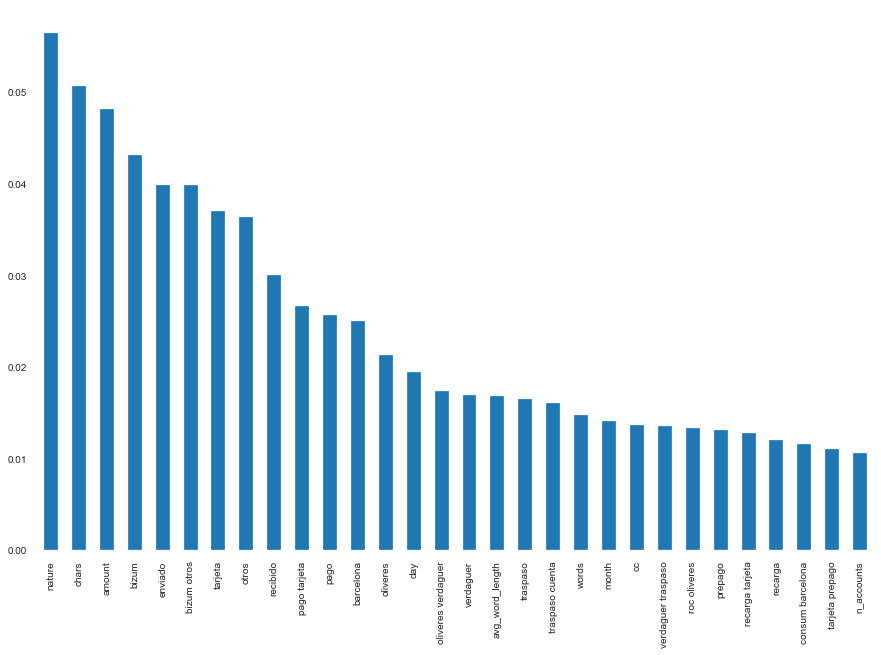

In [26]:
#Show feature importance
pd.Series(clf.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(30).plot.bar(figsize=(15, 10))

One could think having so many dimensions could be an issue, but still we got 10x rows in the training set, so it seems to be enough (performance does not suffer in test set). The model is theoretically perfect using training/test split strategy (we'll point out some remarks later). Let's see what happens if we use cross-validation.

In [27]:
#Gives a warning since the least represented class is less than the number of folds. Stratified kfold is used by default
cv_results = cross_validate(clf, tfidf_X, y, cv=10)
cv_results['test_score']

/home/alvfermar/miniconda3/envs/unnax/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

The model seems to be theoretically perfect using this validation strategy as well.

## 5.Conclusions

Hooray! So we have a perfect model right? 

Well this is not the case. I'll lay out the main reasons here:

* We are working with dummy data. This seems to be a resample of the original data and of course there will be a much more complex casuistry than this one (here we only had values for 18 different categories from the 50+ that there are) and there are a lot of rows in which concepts are *exactly the same* (in fact only 2% of the cases from "concepts_ori" are unique, which leads to a lot of repetition and thus greater chances of detecting patterns correctly.

* In this resample, almost 25% of the categories where 53, this means that we don't know what those *expenses* (at least we know that) are! So it seems that the maximum real accuracy we could have would be of around 75% with this data from the initial model, because literally we have 25% labeled as unkown ("Desconocido").

So, some ideas that come up to my mind to try to improve this situation in real life:

* First of all we would need more data, in order to see all the possible cases and the nuances that may occur, but I assume there is a lot more data in the real context, and if it isn't, then we should come up with a way to get it.

* We would probably need to have our own tokenizer / stemmer / list of stopwords since all that is very vocabualry dependent and for sure bank statement text is very different from normal Spanish language, so we would fail used pre-trained models from NLP libraries. This would probably lead us to a better and simpler feature extraction, which is key for model performance.

* We could also use more advanced NLP preprocessing techniques such as word embeddings, in which words with similar meaning have a similar vector representation, again this should be trained on specific text data for this purpose.

* We could for sure test more complex classifiers (NNs are known to have good performance on text data), but this would require more data and fine parameter tuning.

* We could predict the category_id in two steps: first predicting the parent and then the "child" characteristic. This could be done by building a model to predict the former first, and this prediction would be used as another feature / input to predict the latter.

* It would be probably wise to invest in (or create ourselves) an entity database with different aliases for companies or other kind of entities that may appear in bank statements. This way we would have a very direct relationship between the detected entity and the kind of income/expense at hand.

* Since 25% of our data is not properly labeled, we would need to label it correctly somehow. This could be done by ourselves initially or for example by asking our clients in a gentle and easy manner to classify their expenses (via push notification or something like that) some times. With regard to this, maybe we can find another provider that does better.